In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [17]:
df = pd.read_csv(r"C:\Users\aman\Downloads\train.csv")
df.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


In [18]:
df.isnull().sum()

ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64

In [19]:
df.describe()

,Sourcing Cost
count,550176.000000
mean,108.817286
std,104.390093
min,-196.070000
25%,57.000000
50%,132.000000
75%,146.150000
max,32632.500000


E:\ana\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


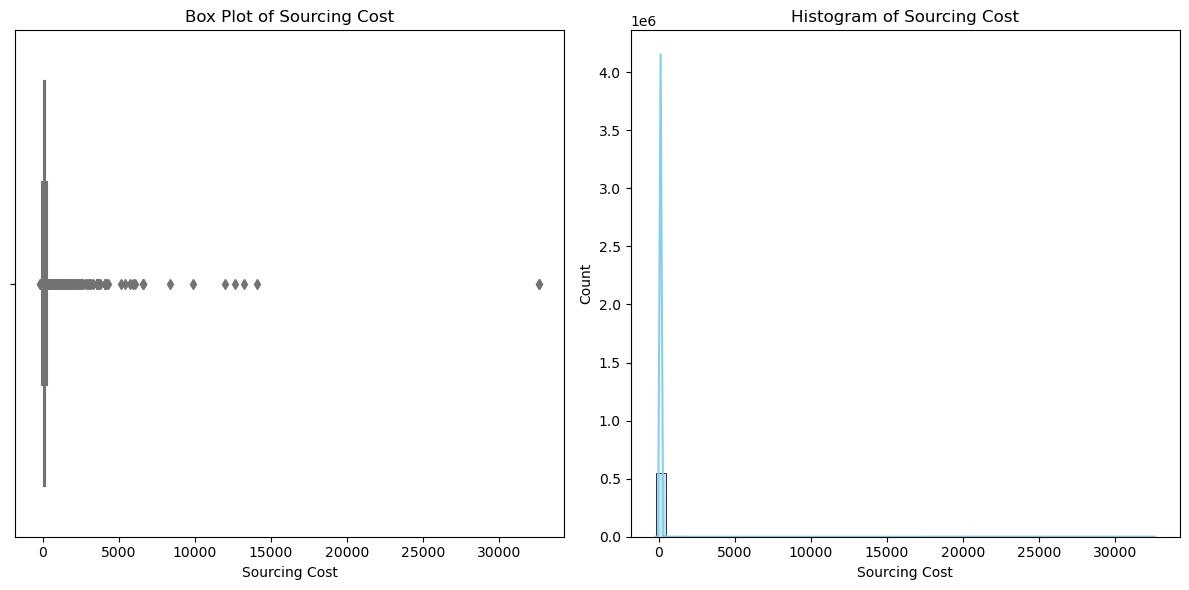

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(df['Sourcing Cost'], color='lightgreen')
plt.title('Box Plot of Sourcing Cost')
plt.subplot(1, 2, 2)
sns.histplot(df['Sourcing Cost'], bins=50, kde=True, color='skyblue')
plt.title('Histogram of Sourcing Cost')
plt.tight_layout()
plt.show()

In [21]:
threshold = 1  
cleaned_df = df[df['Sourcing Cost'] > threshold]
print("Cleaned Dataset:")
print(cleaned_df)


Cleaned Dataset:
       ProductType Manufacturer Area Code Sourcing Channel Product Size  \
0             NTM3           X1       A28        WHOLESALE        Large   
1             NTM2           X1        A9           DIRECT        Large   
2             NTM3           X2       A20           DIRECT        Large   
3             NTM3           X1       A18        WHOLESALE        Small   
4             NTM2           X1       A28           DIRECT        Large   
...            ...          ...       ...              ...          ...   
550171        NTM2           X1        A5           DIRECT        Large   
550172        NTM3           X1       A14           DIRECT        Large   
550173        NTM2           X1        A5           DIRECT        Small   
550174        NTM2           X1        A7           DIRECT        Small   
550175        NTM1           X1        A3           DIRECT        Small   

       Product Type Month of Sourcing  Sourcing Cost  
0            Powder        

In [22]:
Q1 = cleaned_df['Sourcing Cost'].quantile(0.25)
Q3 = cleaned_df['Sourcing Cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


In [23]:
db = cleaned_df[(cleaned_df['Sourcing Cost'] >= lower_bound) & (cleaned_df['Sourcing Cost'] <= upper_bound)]
print("Cleaned Dataset without Outliers:")

Cleaned Dataset without Outliers:


In [24]:
db.describe()

,Sourcing Cost
count,528493.000000
mean,110.035915
std,52.918901
min,1.130000
25%,64.330000
50%,133.300000
75%,146.550000
max,269.770000


E:\ana\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


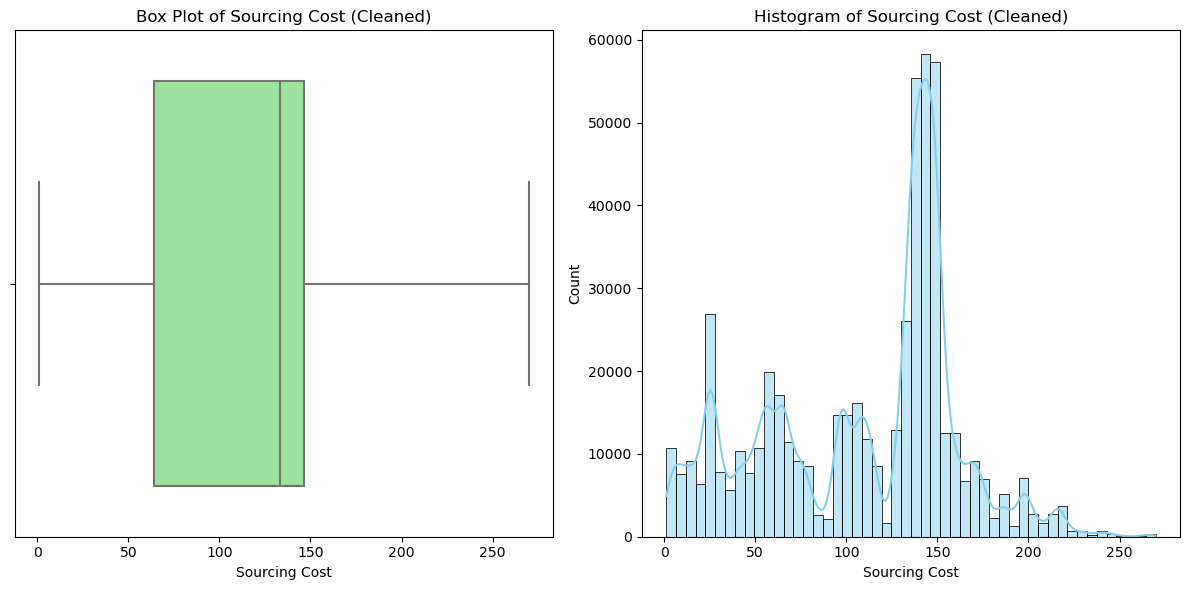

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(db['Sourcing Cost'], color='lightgreen')
plt.title('Box Plot of Sourcing Cost (Cleaned)')
plt.subplot(1, 2, 2)
sns.histplot(db['Sourcing Cost'], bins=50, kde=True, color='skyblue')
plt.title('Histogram of Sourcing Cost (Cleaned)')
plt.tight_layout()
plt.show()


In [26]:
tb = db[['Month of Sourcing', 'Sourcing Cost']]
print(tb)

       Month of Sourcing  Sourcing Cost
0                 May-21          10.16
1                 Oct-20         134.28
2                 Dec-20          12.46
3                 Feb-21         107.22
4                 Nov-20         197.76
...                  ...            ...
550171            Jul-20         136.47
550172            Oct-20          72.56
550173            Mar-21         147.64
550174            Feb-21         150.04
550175            Nov-20         139.42

[528493 rows x 2 columns]


In [27]:
tb['Month of Sourcing'] = pd.to_datetime(tb['Month of Sourcing'], format='%b-%y')
tb.set_index('Month of Sourcing', inplace=True)
tb.dropna(inplace=True)  
forecast_dict = {}


C:\Users\aman\AppData\Local\Temp\ipykernel_21140\1429405609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb['Month of Sourcing'] = pd.to_datetime(tb['Month of Sourcing'], format='%b-%y')
C:\Users\aman\AppData\Local\Temp\ipykernel_21140\1429405609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb.dropna(inplace=True)


In [28]:
ets_model = ExponentialSmoothing(tb['Sourcing Cost'], seasonal='add', seasonal_periods=12)
ets_result = ets_model.fit()
forecast_ets = ets_result.forecast(steps=96) 
forecast_dict['ETS'] = forecast_ets

arima_model = ARIMA(tb['Sourcing Cost'], order=(1, 1, 1))  
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=96)  
forecast_dict['ARIMA'] = forecast_arima


actual_values = tb['Sourcing Cost'].values[-96:]  


E:\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\ana\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
E:\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
E:\ana\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignore

In [29]:
rmse_dict = {}
for model_name, forecast in forecast_dict.items():
    rmse = np.sqrt(mean_squared_error(actual_values, forecast))
    rmse_dict[model_name] = rmse
for model_name, rmse in rmse_dict.items():
    print(f"RMSE for {model_name}: {rmse}")
best_model = min(rmse_dict, key=rmse_dict.get)
print(f"The best model is: {best_model}")

RMSE for ETS: 54.82333054368289
RMSE for ARIMA: 55.689725664150686
The best model is: ETS


In [36]:
best_forecast = forecast_dict[best_model]

forecast_df = pd.DataFrame({'Month of Sourcing': ['Jun-21'] * 96,  
                            'Sourcing Cost': best_forecast})

print(forecast_df)

       Month of Sourcing  Sourcing Cost
528493            Jun-21      98.579063
528494            Jun-21     112.133705
528495            Jun-21     108.236915
528496            Jun-21     108.391934
528497            Jun-21     102.391129
...                  ...            ...
528584            Jun-21      97.251924
528585            Jun-21     103.274757
528586            Jun-21     102.315098
528587            Jun-21     105.157178
528588            Jun-21     114.725240

[96 rows x 2 columns]


In [37]:
test_df = pd.read_csv(r"C:\Users\aman\Downloads\DS_ML Coding Challenge Dataset (1).xlsx - Test Dataset.csv")

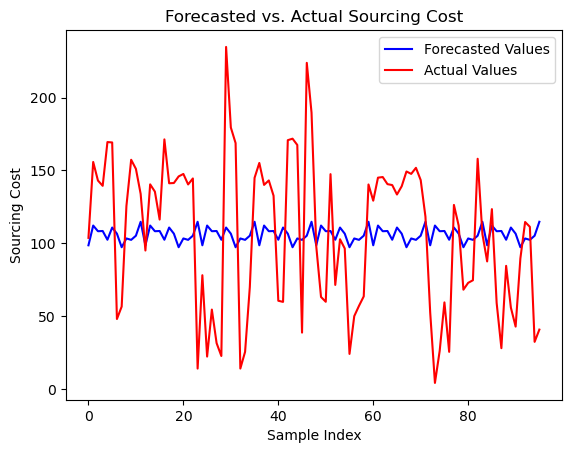

In [38]:
actual_values = test_df["Sourcing Cost"]
plt.plot(range(len(forecast_df)), forecast_df['Sourcing Cost'], label='Forecasted Values', color='blue')
plt.plot(range(len(actual_values)), actual_values, label='Actual Values', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Sourcing Cost')
plt.title('Forecasted vs. Actual Sourcing Cost')
plt.legend()
plt.show()